## DGMD S-14

### Summer 2020

# CUSTOM MOUSE SENSOR CLASSIFIER FOR WEB

## Collaborators:

Vasco Meerman <br/>
Vikram Maduskar

# Overview

This Jupyter notebook presents the data analysis and Machine Learning modelling work for our project which involves classification of sensor fit hand gestures that mimic computer mouse movements.The project is focused on replicating the movements of a traditional mouse using a STM32 sensortile and a python package called PYAUTOGUI. The idea is that you can integrate a sensortile flashed with the appropriate embedded alogorithm and ML into any wearable device or display which instead of requiring the user to manually select options allows, enables control via gestures. Our POC can be extended further to enable people with permanent disabilities or those who have suffered an injury to their fingers or arms, to use this as a fingreband (or headband or a similar device) to control the mouse/cursor movement. Additionally, this can also be implemented for gesture driven interactions in a VR or AR world.

<b>This notebook has been originally created by Vikram Maduskar, I (Vasco Meerman) created this custom one to generate an ML model use for our web application which doesn't have acces to the magnetometer</b>

# Data Description

The dataset used for building the classification models was collected by creating and opening a data port
mapping to the STM32 Sensortile hardware as we moved the sensor by hand. We have capture data fom the sensor's Accelaratometer, Magnetometer and Gyroscope6 along the X,Y and Z axis for 6 different hand gestures for the mouse:Up, Down,Left,Right,Spiral and Wave. We collected data for 15 sets for each movetype type in multiple csv files that were merged to create a single csv file. This file was then split into a training
dataset csv file and a test dataset csv file.

# Our Methodology

**Step 1. Environment Setup** <br/>
**Step 2. Data Setup** <br/>
**Step 3. Exploratory Data Analysis** <br/>
**Step 4. Classifier Model Training & Evaluate Models** <br/>
        Model 1:Logitisc Regression<br/>
        Model 2: SVM <br/>
        Model 3:Random Forest<br/>
        Model 4: AdaBoost <br/>
        Model 5: XGBoost <br/>
**Step 5. Model Selection** <br/>
**Step 6. Hyper Parameter Tuning Of Selected Model** <br/>
**Step 7. Save Persistent Finalized Model to Disk** <br/>

# 1. ENVIRONMENT SETUP

In this section, we will set up our working environment.

In [55]:
# IMPORT LIBRARIES 

# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To build models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, roc_curve, auc, roc_auc_score

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# scikit-learn GridSearch for Grid search cross validation for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# For model Serialization
import pickle
import joblib

# To measure time
from time import time

# 2. DATA SETUP

In [115]:
#Load datasets
train_df = pd.read_csv("all_web_train.csv")
test_df = pd.read_csv("all_web_test.csv")
# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
merged_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
merged_df = merged_df.dropna()

# 3. EXPLORATORY DATA ANALYSIS

In [116]:
merged_df.head()

,sr_no,HostTimestamp,NodeTimestamp,X_mg,Y_mg,Z_mg,X_dps,Y_dps,Z_dps,move_type,Data
0,1,156162,29922.0,21.0,-75.0,1126.0,9.6,0.0,14.1,D,Train
1,2,156222,29928.0,-74.0,-111.0,1162.0,2.1,19.6,23.1,D,Train
2,3,156282,29935.0,-99.0,-98.0,1296.0,-11.8,58.6,18.9,D,Train
3,4,156311,29941.0,-150.0,-120.0,1037.0,-17.2,50.5,31.2,D,Train
4,5,156371,29947.0,-325.0,-116.0,1059.0,-19.6,35.8,31.6,D,Train


In [117]:
print('Shape Train:\t{}'.format(merged_df.shape))
print(merged_df.columns)

Shape Train:	(11146, 11)
Index(['sr_no', 'HostTimestamp', 'NodeTimestamp', 'X_mg', 'Y_mg', 'Z_mg',
       'X_dps', 'Y_dps', 'Z_dps', 'move_type', 'Data'],
      dtype='object')


In [118]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(merged_df.isna().sum().sum()))
merged_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11146 entries, 0 to 11145
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sr_no          11146 non-null  int64  
 1   HostTimestamp  11146 non-null  int64  
 2   NodeTimestamp  11146 non-null  float64
 3   X_mg           11146 non-null  float64
 4   Y_mg           11146 non-null  float64
 5   Z_mg           11146 non-null  float64
 6   X_dps          11146 non-null  float64
 7   Y_dps          11146 non-null  float64
 8   Z_dps          11146 non-null  float64
 9   move_type      11146 non-null  object 
 10  Data           11146 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 1.0+ MB


## Data Visualization

Here we interogate the data visually across many aspects and make key observations. These observations will give us the insights to help us with further data processing and feature engineering

### Plot the Angular velocity Captured by Gyroscope of Various Movements against time

In [119]:
df_left = merged_df[merged_df['move_type'] == "L"]

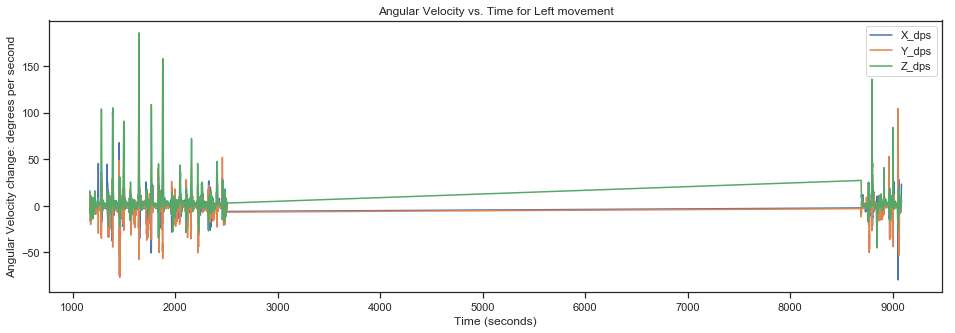

In [120]:
ax = \
df_left[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Left movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [121]:
df_right = merged_df[merged_df['move_type'] == "R"]

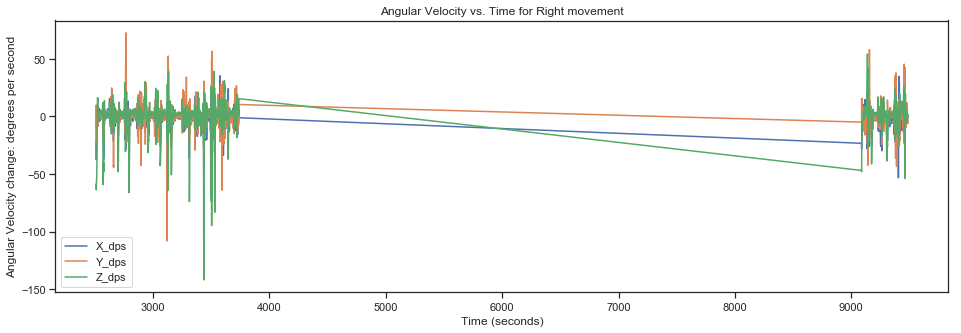

In [122]:
ax = \
df_right[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Right movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [123]:
df_up = merged_df[merged_df['move_type'] == "U"]

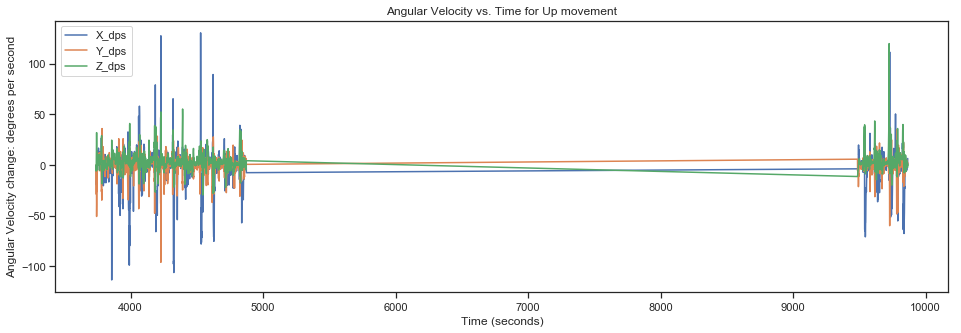

In [124]:
ax = \
df_up[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Up movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [125]:
df_down = merged_df[merged_df['move_type'] == "D"]

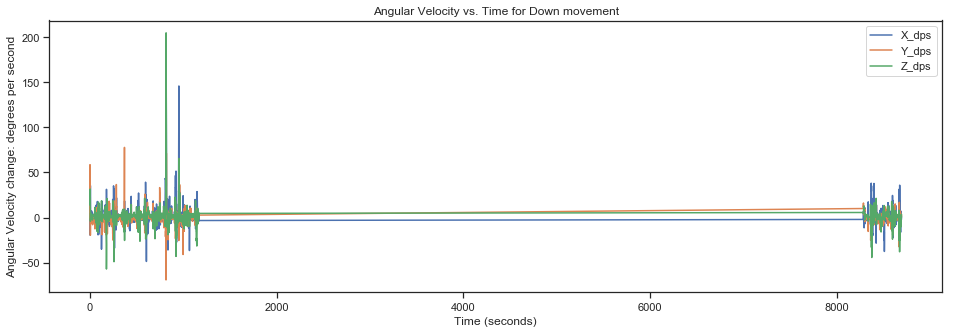

In [126]:
ax = \
df_down[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Down movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [127]:
df_spiral = merged_df[merged_df['move_type'] == "S"]

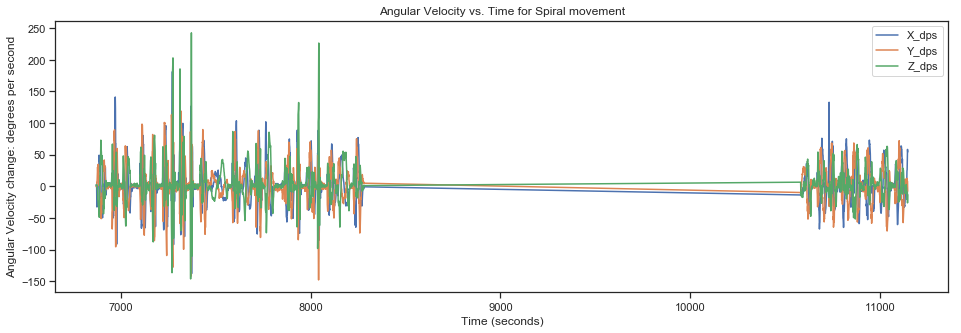

In [128]:
ax = \
df_spiral[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Spiral movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [129]:
df_wave = merged_df[merged_df['move_type'] == "W"]

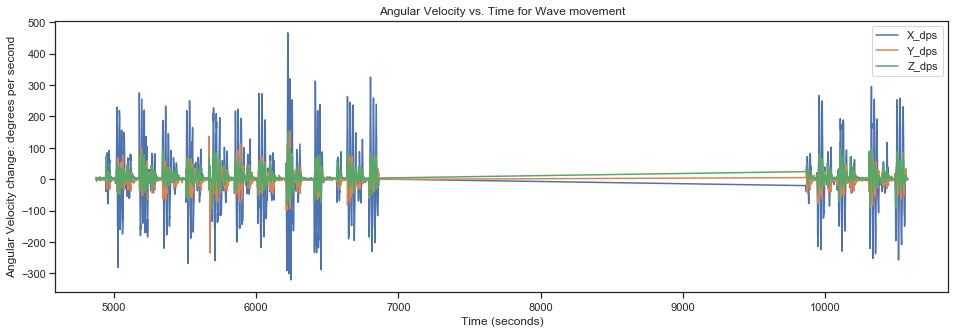

In [130]:
ax = \
df_wave[["X_dps", "Y_dps", "Z_dps"]].plot(title = "Angular Velocity vs. Time for Wave movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Angular Velocity change: degrees per second");

In [131]:
df_left[["X_mg", "Y_mg", "Z_mg"]]

,X_mg,Y_mg,Z_mg
1169,6.0,-995.0,-38.0
1170,23.0,-1036.0,93.0
1171,-103.0,-1010.0,9.0
1172,8.0,-990.0,45.0
1173,-100.0,-997.0,9.0
...,...,...,...
9083,-19.0,-985.0,161.0
9084,-31.0,-979.0,152.0
9085,-16.0,-960.0,139.0
9086,-29.0,-966.0,195.0


### Plot the Orientation Captured by Magnenometer for Various Movements against time

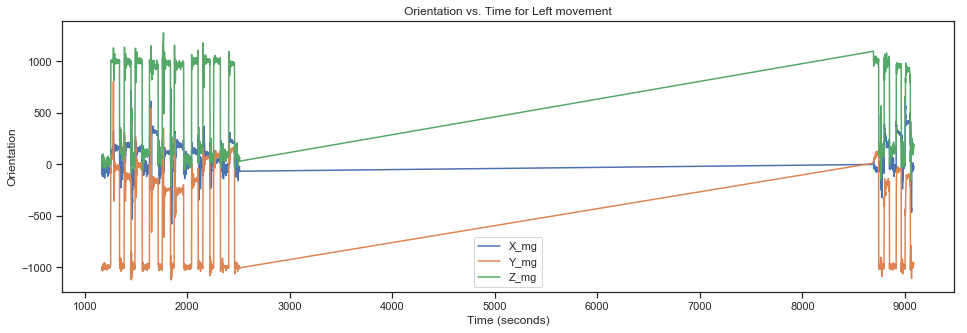

In [132]:
ax = \
df_left[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Left movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

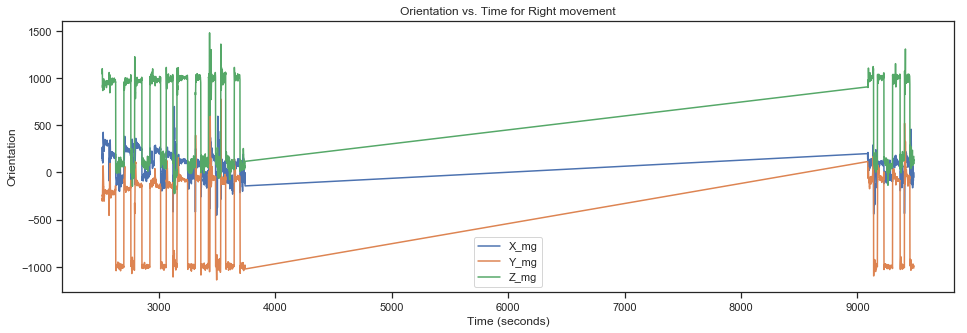

In [133]:
ax = \
df_right[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Right movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

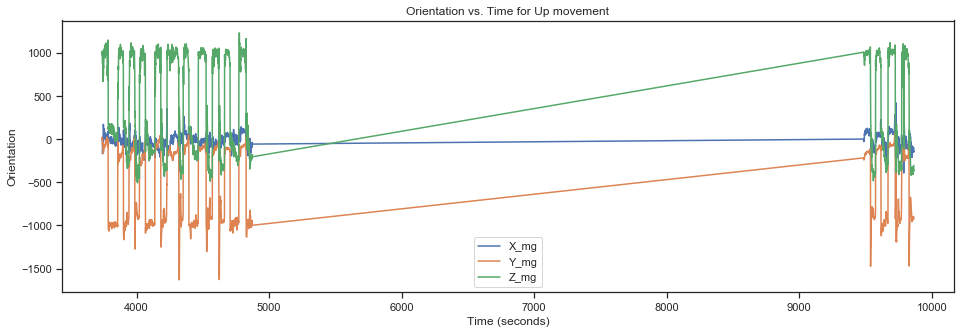

In [134]:
ax = \
df_up[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Up movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

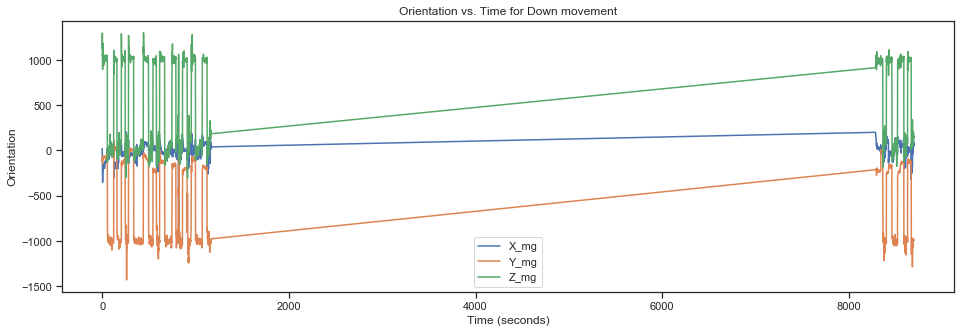

In [135]:
ax = \
df_down[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Down movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

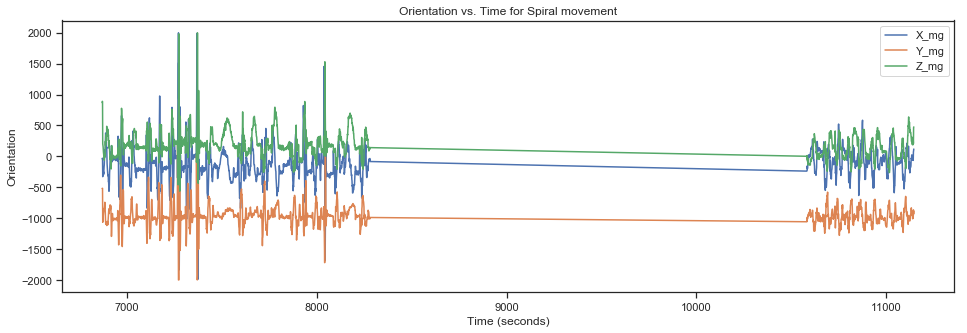

In [136]:
ax = \
df_spiral[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Spiral movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

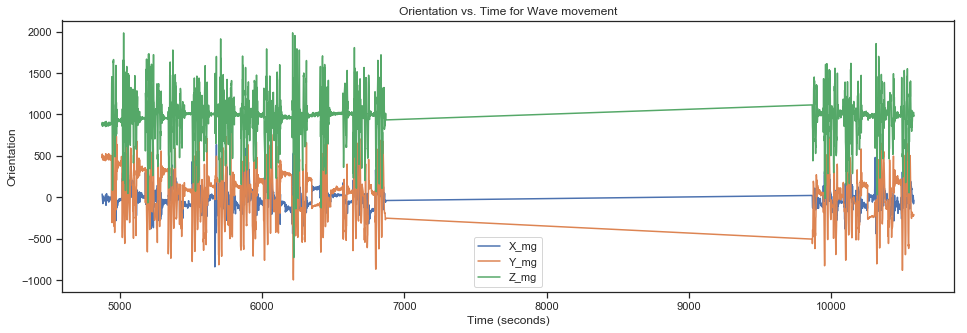

In [137]:
ax = \
df_wave[["X_mg", "Y_mg", "Z_mg"]].plot(title = "Orientation vs. Time for Wave movement",
                                           figsize=(16,5));
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Orientation");

### Observations:

We observe that the plots indicate mostly jerkey movements as the spacing between the peaks for acceleration, angular velocity or orientaion is not constant across any of the three spatial dimensions. The distributions are  denser at the begining of movements and also towards the ending which indicates swift movement in between. Such a complex data pattern requires an advanced technique like machine learning to represent the patterns and classify correctly. 

## Pair Plots

Here we generate some pair plots to observe the distribution of data from one feature to the other.

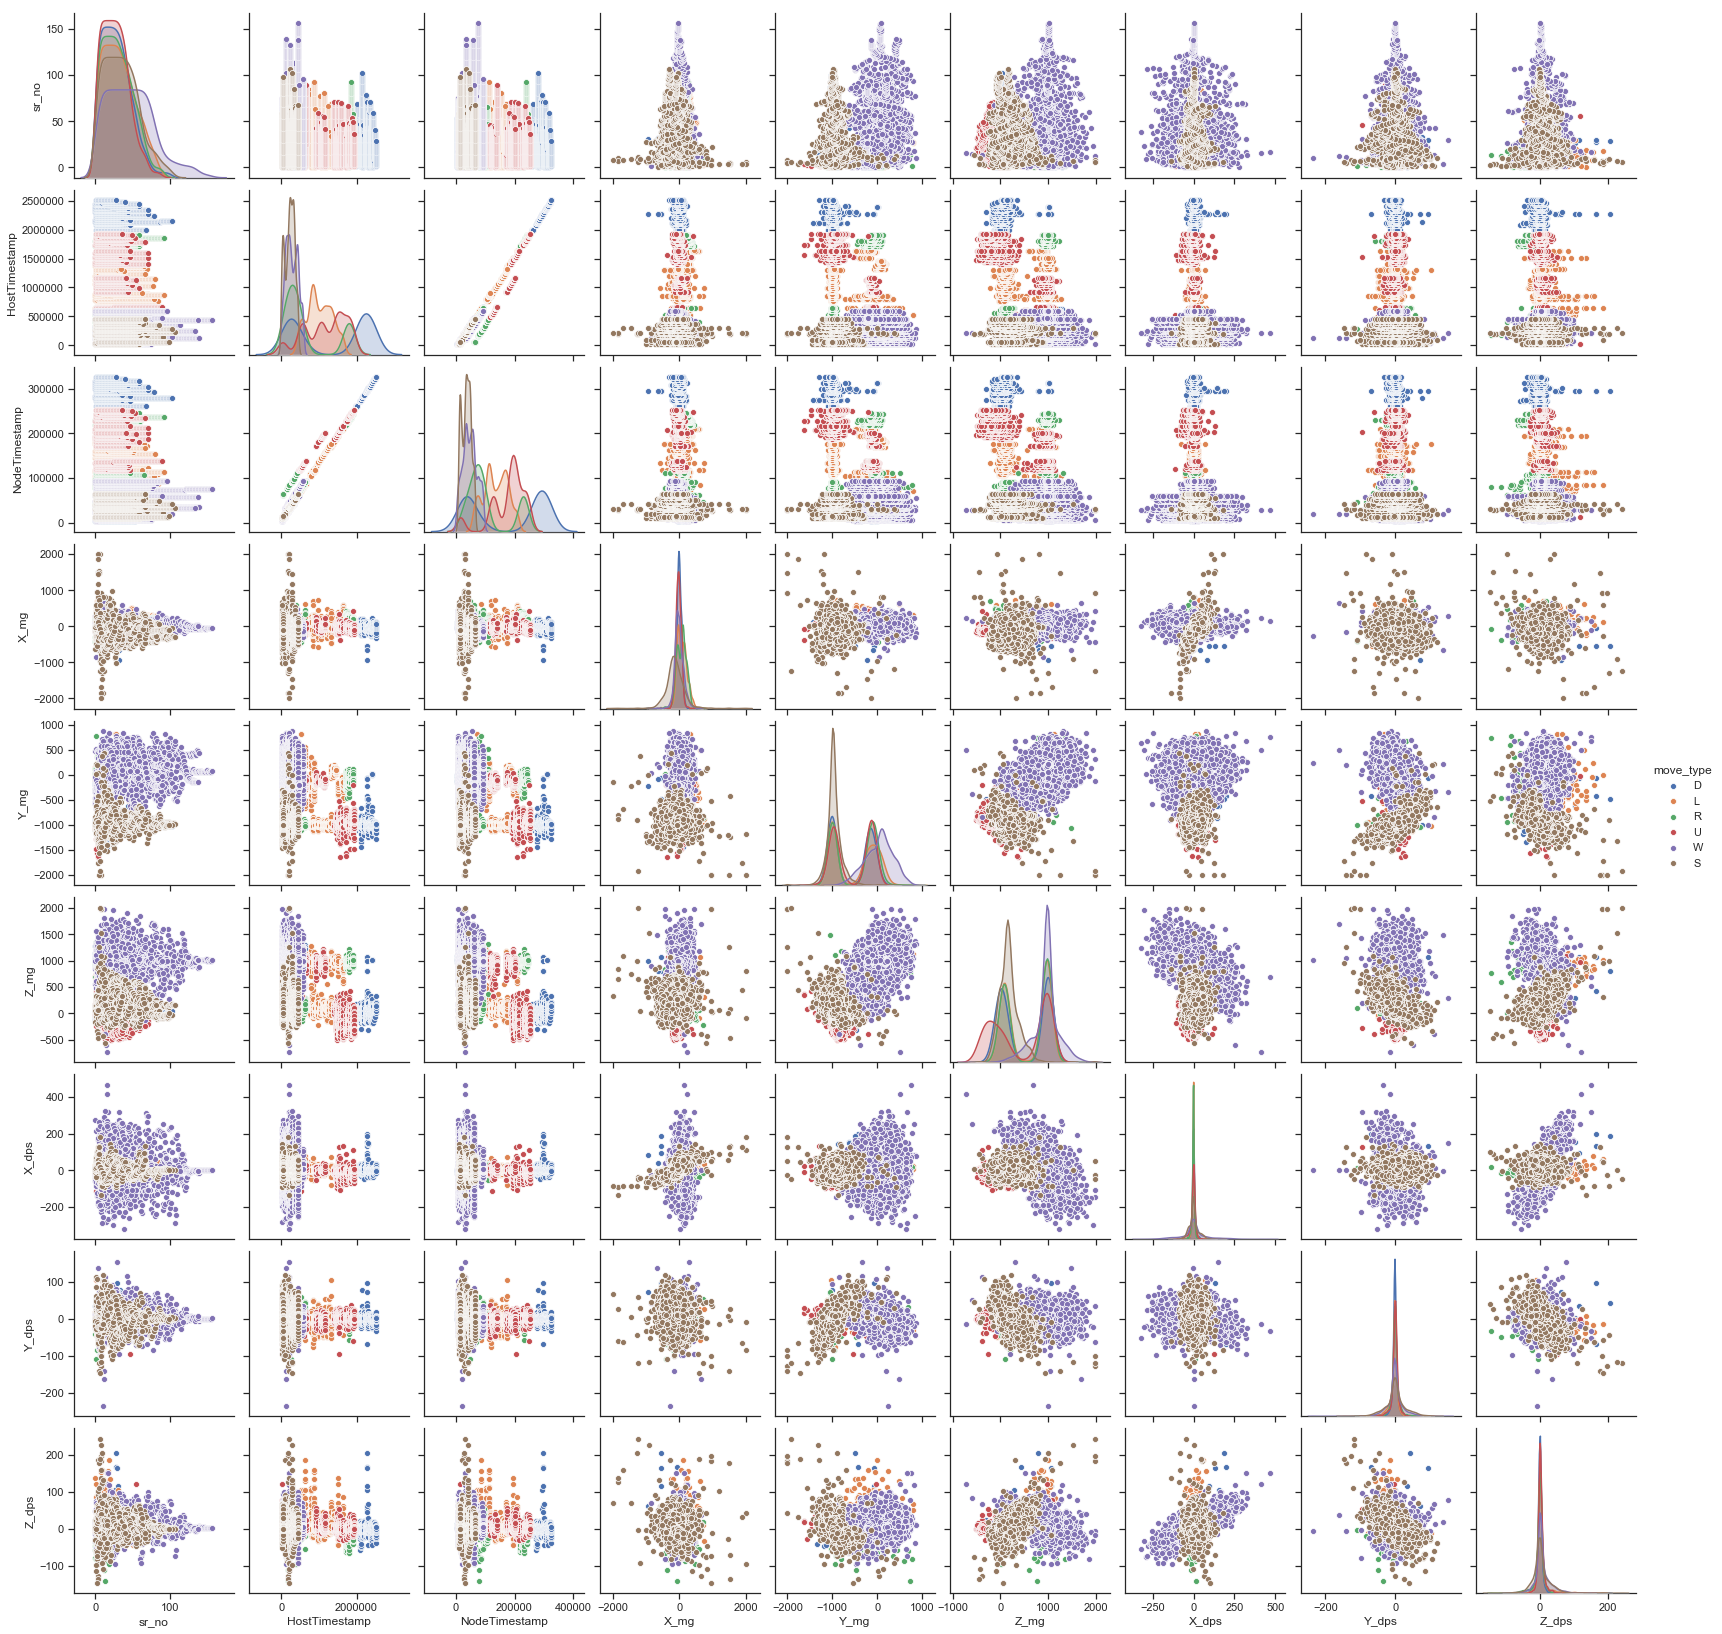

In [138]:
# Use Seaborn library to plot the pairs
sns.set(style="ticks")
sns.pairplot(merged_df, hue="move_type")

### Observations

The above pair plots reflect the conditional probabilities as to how the X,Y,Z dimensions of the person's acceleration, angular velocity and orientation correlate with each other for each movement. The diagonal plots indicate that the signal distributions are more or less gaussian. We can also see that the distributions are centered close to each other in the bottom triangle. Overall, the signal distributions appear aprox normal which means they are amenable to statsitical analysis techniques.

### Pearson Correlation Heatmap

Here we generate some correlation plots of the features to see the inter relations between the features. To do
so, we will utilise the Seaborn plotting package to plot heatmaps of the Pearson correlations between the
features.

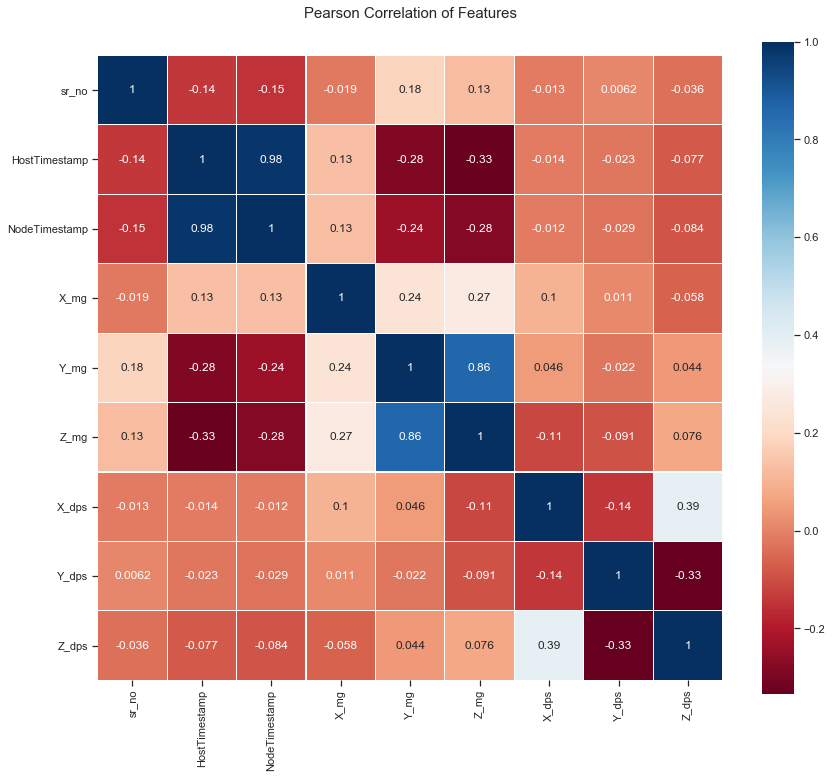

In [139]:
# Feature selection
drop_elements = ['move_type','Data']
merged_df1=merged_df.copy()
merged_df1 = merged_df1.drop(drop_elements, axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(merged_df1.astype(float).corr(),linewidths=0.1,vmax=1.0,
square=True, cmap=colormap, linecolor='white', annot=True)

### Observations:

The Pearson Correlation plot tells us is that there are not too many features strongly correlated with one
another.This means that there isn't much redundant or superfluous data in our training set and that each feature
carries with it some unique information. The lot tells us that most correlated features are Y_mg, Z_mg,X_mGa,
Y_mGa. For now, I'll leave both features in the data set.

### Sensor Movement Type Labels Distribution

In [140]:
# Create label
label_data = merged_df.copy()
label = label_data.pop('move_type')

# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
y = label_counts,
marker = dict(color = colors))
layout = go.Layout(title = 'Sensor Movements Label Distribution',
xaxis = dict(title = 'move_type'),
yaxis = dict(title = 'Count'))
fig = go.Figure(data=[data], layout=layout)
iplot(fig)

### Observations:

We observe that the label count for "W" (Wave movement) is about 20% higher than the counts of other labels but there are not wide differences among the other labels. As such, the label distribution is not signficantly unbalanced and we need not correct it for imbalance.

### Classes Separation Exploration for the Sensor Movement Types

In [141]:
X = merged_df.copy()
#tsne_data = tsne_data.pop('Data')
X = X.drop(['move_type', 'Data'], axis=1)
X=X.iloc[:,2:-1]
X

,NodeTimestamp,X_mg,Y_mg,Z_mg,X_dps,Y_dps
0,29922.0,21.0,-75.0,1126.0,9.6,0.0
1,29928.0,-74.0,-111.0,1162.0,2.1,19.6
2,29935.0,-99.0,-98.0,1296.0,-11.8,58.6
3,29941.0,-150.0,-120.0,1037.0,-17.2,50.5
4,29947.0,-325.0,-116.0,1059.0,-19.6,35.8
...,...,...,...,...,...,...
11141,64924.0,-64.0,-1001.0,269.0,24.1,12.7
11142,64930.0,-64.0,-1001.0,269.0,26.5,10.4
11143,64936.0,70.0,-865.0,207.0,48.7,8.3
11144,64943.0,95.0,-934.0,464.0,58.4,8.1


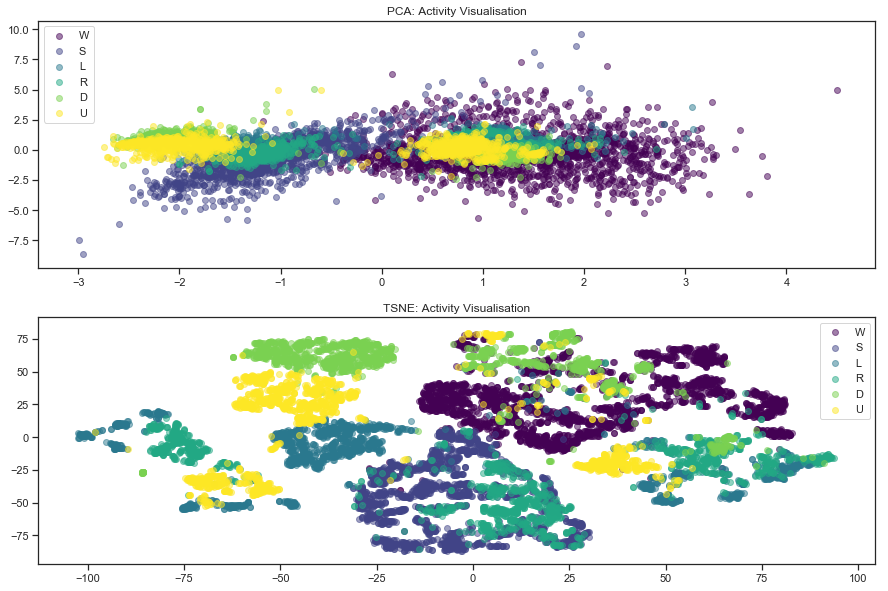

In [142]:
#tsne_data = merged_df.copy()
#tsne_data = tsne_data.pop('Data')

# Standardize the dataset
scl = StandardScaler()
X_std = scl.fit_transform(X)

# Reduce dimensions (speed up) by pca
pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(X_std)

# Feed reduced pca data to further transform data for tsne
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_data)

# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity for PCA
for i, group in enumerate(label_counts.index):
 #Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=pca_data[mask][:,0], y=pca_data[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('PCA: Activity Visualisation')
axarr[0].legend()

# Plot each activity for TSNE
for i, group in enumerate(label_counts.index):
# Mask to separate sets
    mask = (label==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[1].set_title('TSNE: Activity Visualisation')
axarr[1].legend()

### Observations:

From the above plost we can observe that the movement types are fairly identifiable or separable with the tsne approach. This
further implies that a good classifier model should be able to identity the classes correctly and with reasonable
accuracy.

# 4. CLASSIFIER MODEL TRAINING & EVALUATION

### Evaluation Metrics
**Accuracy:** Accuracy is the percentage of labels correctly classified from the total number of predictions made.<br/>
**F Measures: Precision & Recall** <br/>
**Precision:** Precision is defined as the ratio of true positive (TP) divided by the sum of the TP and false positives (Fp)<br/>
**Recall:** Recall is the ratio between TP divided by the sum of TP and false negatives (FN)

In [143]:
# Create label
label=merged_df.copy()
label = label.pop('move_type')

#### Create training and test data

In [144]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(pca_data, label_encoded, random_state=3)

## MODEL 1: Logistic Regression

In [145]:
                                                  
#Build the Logistic Regression Classifier
clf1 = LogisticRegression(random_state=0)
                                                    
#Train the model using the training sets
clf1.fit(X_train, y_train)

t0=time()
#Predict the response for test dataset
y_pred = clf1.predict(X_test)
print("prediction time:", round(time()-t0, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
                                                    
# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))
                                                    
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

prediction time: 0.0 s
Accuracy: 0.5511302475780409
Precision: [0.08305648 0.54245283 0.32160804 0.76650564 0.371875   0.67462039]
Recall: [0.06811989 0.53240741 0.15571776 0.94071146 0.32872928 0.87729196]


## Model 2: SVM

In [146]:
#Build the SVM Classifier
clf2 = svm.SVC(kernel='linear') # Linear Kernel

#Train the SVM model using the training sets
clf2.fit(X_train, y_train)

t2=time()
#Predict the response for test dataset
y_pred = clf2.predict(X_test)
print("prediction time:", round(time()-t2, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

prediction time: 0.178 s
Accuracy: 0.6368855400071761
Precision: [0.35412475 0.63114754 0.47468354 0.81770833 0.66438356 0.73363431]
Recall: [0.47956403 0.53472222 0.3649635  0.93083004 0.2679558  0.9167842 ]


## MODEL 3: Random Forest

In [147]:
#Build the Random Forest Classifier
clf3 = RandomForestClassifier(max_depth=3, random_state=0)

#Train the model using the training sets
clf3.fit(X_train, y_train)

t3=time()
#Predict the response for test dataset
y_pred = clf3.predict(X_test)
print("prediction time:", round(time()-t3, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

prediction time: 0.032 s
Accuracy: 0.6881951919626839
Precision: [0.87142857 0.55441176 0.         0.67492711 0.75531915 0.73412271]
Recall: [0.4986376  0.87268519 0.         0.91501976 0.58839779 0.96191819]


/Users/vascowerk/.local/share/virtualenvs/Jupyter-aVAuezJH/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## MODEL 4: AdaBoost

In [148]:
#Build the AdaBoost Classifier
clf4 = AdaBoostClassifier(n_estimators=100)

#Train the model using the training sets
clf4.fit(X_train, y_train)

t4=time()
#Predict the response for test dataset
y_pred = clf4.predict(X_test)
print("prediction time:", round(time()-t4, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

prediction time: 0.064 s
Accuracy: 0.4061715105848583
Precision: [0.13885778 0.42521368 0.18729097 0.76071429 0.45934959 0.66666667]
Recall: [0.33787466 0.46064815 0.13625304 0.84189723 0.3121547  0.30183357]


## MODEL 5: XGBoost

In [149]:
#Build the XGBoost Classifier
clf5 = XGBClassifier(n_estimators=100,learning_rate=0.02,objective='multi:softmax')

#Train the model using the training sets
clf5.fit(X_train, y_train)

t5=time()
#Predict the response for test dataset
y_pred = clf5.predict(X_test)
print ("prediction time:", round(time()-t5, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

prediction time: 0.017 s
Accuracy: 0.8726228919985648
Precision: [0.8503937  0.87272727 0.81176471 0.85090909 0.90857143 0.91184573]
Recall: [0.88283379 0.88888889 0.67153285 0.92490119 0.87845304 0.93370945]


# 5. BEST MODEL SELECTION

Based upon the above model performance statistics, we can observe that the XGBoost model at 90% accuracy,
Precision between 84% to 95% and recall between 80% to 99% for the 6 classes. Comparing the model performancewith other models we observe that **Model 5(XGBoost)** easily outperforms the other models by a wide margin. The difference in performance is so large that there is no need to even consider an ensemble approach and going with XGBoost as the lone model will be the best approach in our case. Therefore, we select this model as the winner and try to tune in further and see if it imrpves further.

# 6. MODEL HYPER PARAMETERS TUNING

## Model Tuning Approach: Grid Search Cross Validation 

In [150]:
estimator = XGBClassifier(
objective= 'multi:softmax',
nthread=4,
seed=42
)

In [151]:
parameters = {
'max_depth': range (2, 10, 1),
'n_estimators': range(60, 220, 40),
'learning_rate': [0.1, 0.01, 0.05]
}

In [152]:
grid_search = GridSearchCV(
estimator=estimator,
param_grid=parameters,
scoring = 'accuracy',
n_jobs = 10,
cv = 10,
verbose=True
)

In [153]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  9.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 18.4min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 24.4min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...ead=4,
                                     num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
   

In [154]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


### Apply the best estimator hyper parameters to the selected model

In [156]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(pca_data, label_encoded, random_state=3)

#Build the XGBoost Classifier
clf5_t = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#Train the model using the training sets
clf5_t.fit(X_train, y_train)

t0=time()
#Predict the response for test dataset
y_pred = clf5_t.predict(X_test)
print("prediction time:", round(time()-t0, 3), "s")

# Test the model
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Precision & Recall of the model: What percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))


prediction time: 0.065 s
Accuracy: 0.922497308934338
Precision: [0.91056911 0.93939394 0.86783042 0.91666667 0.93314763 0.94810659]
Recall: [0.91553134 0.93287037 0.84671533 0.93478261 0.92541436 0.95345557]


## Model Tuning Result:

We see a massive improvement in the performance of our model!
The accuracy has improved from 85% to aprox 98%.
We see similar improvements in Precision and Recall as well.

# 7. SAVE PERSISTANT FINAL MODEL TO DISK

After training our model, it is desirable to have a way to persist the model for future use without having to
retrain. Therefore, we save our trained and hypertuned model to the disk from where it can be re-loaded and
used anytime to perform classifications for new input data. The model is stored in a serialized form and deserialized
when re-loaded for use. We will use the joblib utility to create and save the seralized persistent model.This fully trained and persistent model is now fully ready to be deployed and invoked in a production environment and peform classification for new input data going forward.

In [157]:
# Final classifier model name
model=clf5_t
# save the model to disk
filename = 'finalized_web_model.sav'
joblib.dump(model, filename)

['finalized_web_model.sav']

In [158]:
import pickle
model_p=clf5_t
filename_p = 'finalized_web_model_p.sav'
pickle.dump(model, open(filename_p, 'wb'))

In [159]:
filename_scl='scalar_web.sav'
joblib.dump(scl, filename_scl)

['scalar_web.sav']

In [160]:
filename_scl_p='scalar_web_p.sav'
pickle.dump(scl, open(filename_scl_p,'wb'))


In [161]:
filename_pca='pca_web.sav'
joblib.dump(pca, filename_pca)

['pca_web.sav']

In [162]:
filename_pca_p='pca_web_p.sav'
pickle.dump(pca_data, open(filename_pca_p,'wb'))

In [163]:
filename_tsne='tsne_web.sav'
joblib.dump(tsne, filename_tsne)

['tsne_web.sav']

In [164]:
filename_tsne_p='tsne_web_p.sav'
pickle.dump(tsne_transformed, open(filename_tsne_p,'wb'))

In [165]:
filename_label='label_web_encoded.sav'
joblib.dump(enc, filename_label)

['label_web_encoded.sav']

In [166]:
filename_label_p='label_encoded_web_p.sav'
pickle.dump(label_encoded, open(filename_label_p,'wb'))

# Load Persistant Finalized Model from Disk

The finalized model that is stored on the disk can be re-loaded and used anytime to perform classification on
new data. The model is de-serialzed when re-loading from disk.

In [167]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.922497308934338


### End Of Notebook

In [168]:
!ls


Mouse_Sensor_Classifier_v2.0.ipynb pca_web.sav
all_web_test.csv                   pca_web_p.sav
all_web_train.csv                  scalar_web.sav
finalized_web_model.sav            scalar_web_p.sav
finalized_web_model_p.sav          tsne_web.sav
label_encoded_web_p.sav            tsne_web_p.sav
label_web_encoded.sav
